In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import math
SLOPE = -3.379675
INTERCEPT = 50.84176

In [2]:
data = pd.read_csv('israel.csv')
data['log10Load'] = (data['sample_viral_ct']-INTERCEPT)/SLOPE
data['log10Load'] = data['log10Load'].fillna(value=0)
data_pos = data.loc[data['log10Load'] > 0]
data_pos

,sample_id,pool_id,result,sample_viral_ct,sample_human_ct,pool_human_ct,pool_viral_ct,month,log10Load
2662,28467,4830,pos,19.12,19.49,23.200,23.354,4,9.386039
2692,125617,4851,pos,30.98,18.56,25.588,33.696,4,5.876825
8184,3062,15464,pos,26.00,23.00,24.339,27.214,4,7.350340
10100,116101,329,pos,18.96,20.78,25.817,25.328,5,9.433380
10612,20751,901,pos,23.74,27.02,30.040,29.256,5,8.019043
...,...,...,...,...,...,...,...,...,...
133615,57679,17710,pos,19.79,22.07,24.485,22.500,9,9.187795
133616,55204,17710,pos,15.45,22.07,24.485,22.500,9,10.471942
133617,71106,17710,pos,27.00,21.82,24.485,22.500,9,7.054453
133658,64883,17790,pos,31.86,25.10,27.603,37.504,9,5.616445


## Basic Testing Infrastructure

In [3]:
def run_test(load):
    return INTERCEPT + SLOPE*load

def semi_quant(load,th1=24,th2=39):
    ct = run_test(load)
    if ct<th1:
        return 2
    elif th1<ct<th2:
        return 1
    else:
        return 0

def basic(load,thg=39):
    ct = run_test(load)
    if ct<thg:
        return 1
    else:
        return 0
    
def indiv_test(load,th):
    ct = run_test(load)
    if ct<th:
        return 1
    else:
        return 0
    
def run_baseline(table, th):
    levels = []
    cts = []
    for index, individual in table.iterrows():
        if individual['toTest']:
            cts.append(run_test(individual['log10Load']))
            levels.append(indiv_test(individual['log10Load'],th))
    table['Truth'] = levels
    table['TrueCT'] = cts
    return table

In [4]:
def group_test(table,g,th1,th2,coln):
    
    test_count = 0
    table = table.sample(frac=1).reset_index(drop=True) #shuffle data
    index = 0
    levs = []
    groups = []
    #print(math.floor(len(table)/g))
    for i in range(math.ceil(len(table)/g)):
        group = table[index:min(index+g,len(table))]
        #print(i,index,len(group))
        
        group_load = 0
        for j, individual in group.iterrows():
            group_load += pow(10,individual['log10Load'])
        group_load = np.log10(group_load/len(group))
        
        test_count+=1
        group_res = semi_quant(group_load,th1,th2)
        levs+= [group_res]*len(group)
        groups+= [i]*len(group)
        
        index+=len(group)
        
    table[coln] = levs
    table[coln+'_group'] = groups
    
    return table,test_count

def basic_group_test(table,g,thg,coln):
    test_count = 0
    table = table.sample(frac=1).reset_index(drop=True) #shuffle data
    index = 0
    levs = []
    groups = []
    #print(math.floor(len(table)/g))
    for i in range(math.ceil(len(table)/g)):
        group = table[index:min(index+g,len(table))]
        #print(i,index,len(group))
        
        group_load = 0
        for j, individual in group.iterrows():
            group_load += pow(10,individual['log10Load'])
        group_load = np.log10(group_load/len(group))
        
        test_count+=1
        group_res = basic(group_load,thg)
        levs+= [group_res]*len(group)
        groups+= [i]*len(group)
        
        index+=len(group)
        
    table[coln] = levs
    table[coln+'_group'] = groups
    
    return table,test_count
        
    

## Two Step Group Testing Function

In [5]:
def has_infected(inId,group):
    infected = {(1,1),(2,1),(1,2),(2,2)}
    has_infected = 0
    for index, individual in group.iterrows():
        scores = (individual['Test1'],individual['Test2'])
        if (scores in infected) and individual['IDs']!=inId:
            has_infected = 1
            #print(individual['IDs'],inId, scores)
    return has_infected

def two_step(table,g,th1,th2,thi):
    count = 0
    
    table,t1_count = group_test(table,g,th1,th2,'Test1')
    table,t2_count = group_test(table,g,th1,th2,'Test2')
    count = count + t1_count+ t2_count
    
    clean = {(1,0),(0,1),(0,0)}
    infected = {(1,1),(2,1),(1,2),(2,2)}
    
    #print(table.columns)
    final=[]
    indiv_tested = []
    for index, individual in table.iterrows():
        scores = (individual['Test1'],individual['Test2'])
        if scores in clean:
            final.append(0)
            indiv_tested.append(False)
        elif scores in infected:
            #final.append(1)
            count+=1
            final.append(indiv_test(individual['log10Load'],thi))
            indiv_tested.append(True)
        else:
            if scores[0]==2:
                group_to_test = 'Test1_group'
            else:
                group_to_test = 'Test2_group'
            
            t1g = has_infected(individual['IDs'],table.loc[table[group_to_test] == individual[group_to_test]])
            if t1g:
            #if False:
                final.append(0)
                indiv_tested.append(False)
            else:
                count+=1
                final.append(indiv_test(individual['log10Load'],thi))
                indiv_tested.append(True)
    
    table['Final'] = final
    table['TestedIndiv'] = indiv_tested
    return table, count            
    

## Dorfman Function

In [6]:
def dorfman(table,g,thg,thi):
    count = 0
    
    table,tg_count = basic_group_test(table,g,thg,'Test1')
    count = count + tg_count
    
    final=[]
    indiv_tested = []
    for index, individual in table.iterrows():
        score = individual['Test1']
        if score==0:
            final.append(0)
            indiv_tested.append(False)
        else:
            count+=1
            final.append(indiv_test(individual['log10Load'],thi))
            indiv_tested.append(True)
    
    table['Final'] = final
    table['TestedIndiv'] = indiv_tested
    return table, count            
    

In [16]:
p = 0.1
gs = [2,3,5,8,12,15,20]
count_lsg = []
fnr_lsg = []
fnr_sds = []
count_sds = []
for g in gs:
    count_r = []
    fnr_r =[]
    for r in range(30):
        loads = list(data_pos['log10Load']) + [0 for i in range(math.ceil(len(data_pos)/p) - len(data_pos))]
        data_table = pd.DataFrame(loads,columns=['log10Load'])
        data_table['IDs'] = [i for i in range(len(data_table))]
        data_table['toTest'] = [True for i in range(len(data_table))]
        data_table = data_table.sample(frac=1).reset_index(drop=True)
        data_table = data_table[:10000]
        data_table = run_baseline(data_table,36)
        th2 = 36+(np.log10(g)*np.abs(SLOPE))
        th1 = 21 +(np.log10(g)*np.abs(SLOPE))
        test1,count = two_step(data_table,g,th1,th2,36)
        cnf_matrix = confusion_matrix(test1['Truth'], test1['Final'])
        tn, fp, fn, tp = cnf_matrix.ravel()
        count_r.append(count)
        fnr_r.append(fn/(tp+fn))
    count_lsg.append(np.mean(count_r))
    fnr_lsg.append(np.mean(fnr_r))
    fnr_sds.append(np.std(fnr_r))
    count_sds.append(np.std(count_r))

In [17]:
p = 0.1
gs = [2,3,5,8,12,15,20]
dorf_count_lsg = []
dorf_fnr_lsg = []
dorf_fnr_sds = []
dorf_count_sds = []
for g in gs:
    count_r = []
    fnr_r =[]
    for r in range(30):
        loads = list(data_pos['log10Load']) + [0 for i in range(math.ceil(len(data_pos)/p) - len(data_pos))]
        data_table = pd.DataFrame(loads,columns=['log10Load'])
        data_table['IDs'] = [i for i in range(len(data_table))]
        data_table['toTest'] = [True for i in range(len(data_table))]
        data_table = data_table.sample(frac=1).reset_index(drop=True)
        data_table = data_table[:10000]
        data_table = run_baseline(data_table,36)
        th2 = 36+(np.log10(g)*np.abs(SLOPE))
        test1,count = dorfman(data_table,g,th2,36)
        cnf_matrix = confusion_matrix(test1['Truth'], test1['Final'])
        tn, fp, fn, tp = cnf_matrix.ravel()
        count_r.append(count)
        fnr_r.append(fn/(tp+fn))
    dorf_count_lsg.append(np.mean(count_r))
    dorf_fnr_lsg.append(np.mean(fnr_r))
    dorf_fnr_sds.append(np.std(fnr_r))
    dorf_count_sds.append(np.std(count_r))

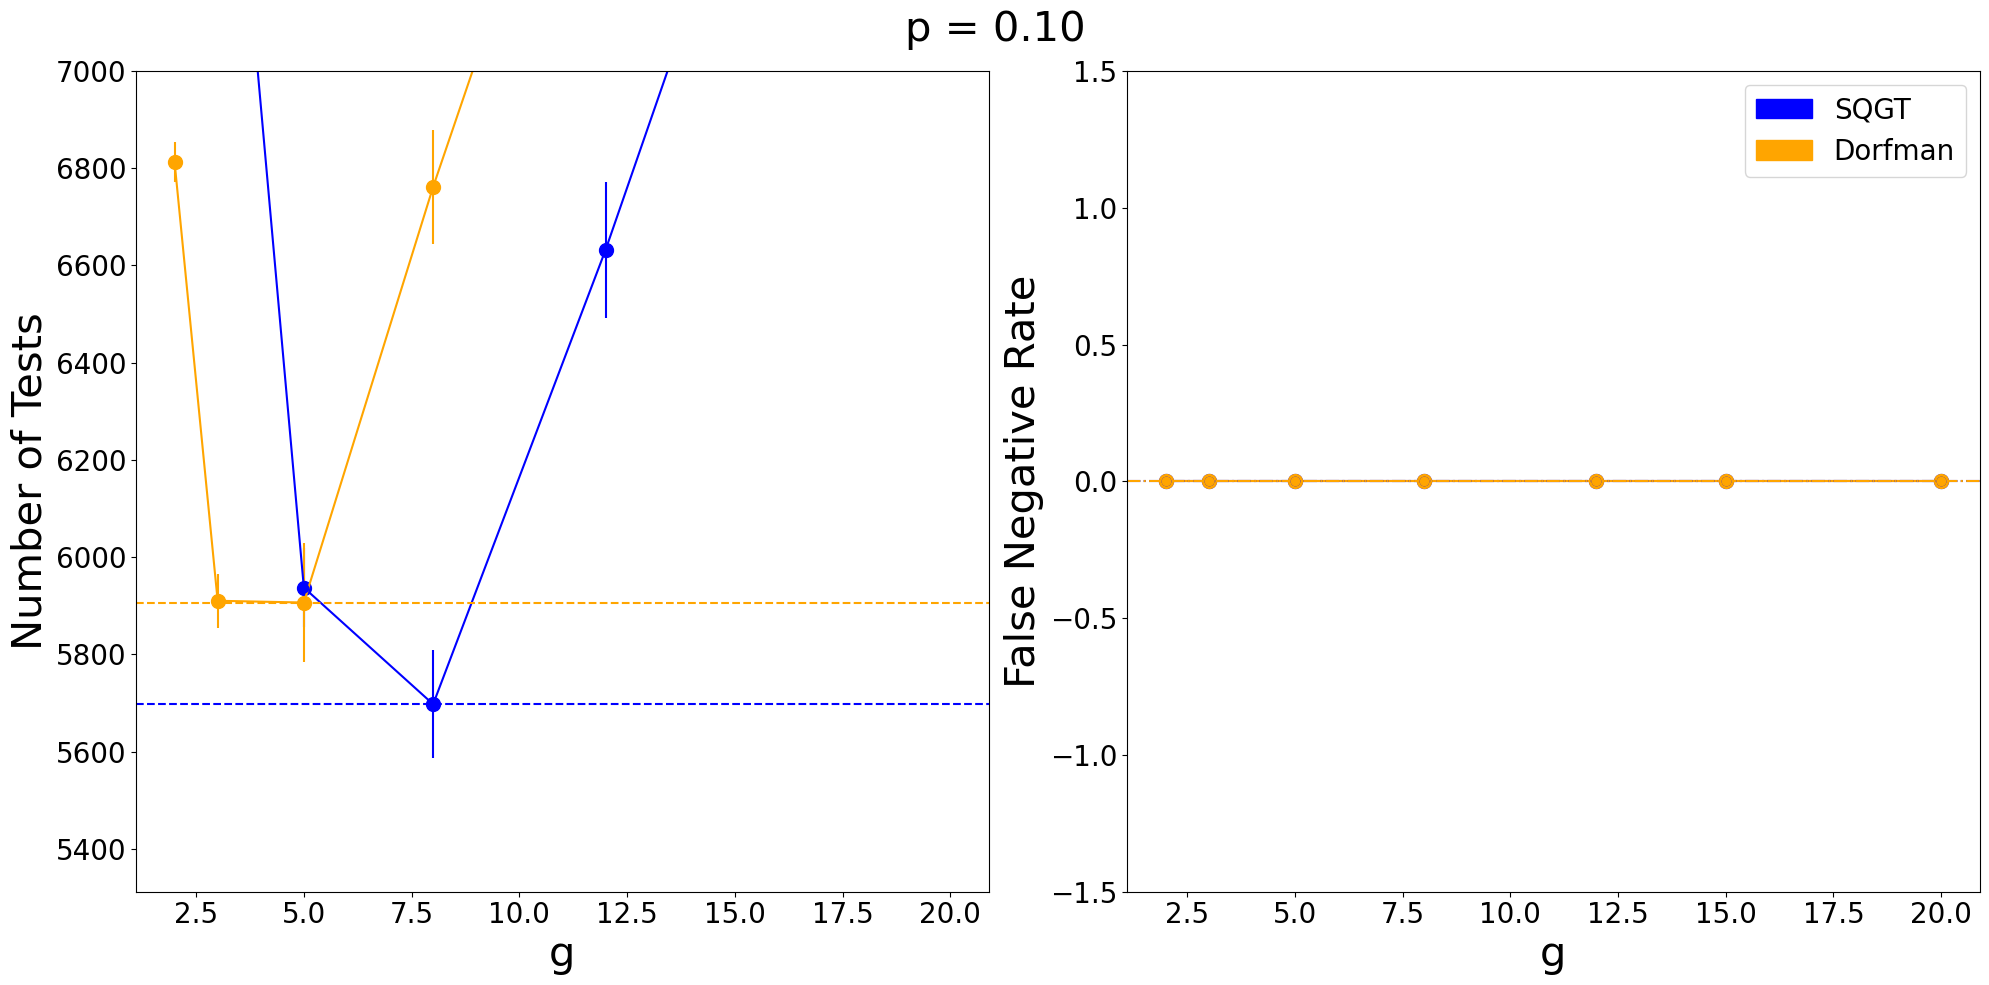

In [18]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
"""ax1.plot(ps,count_ls,marker='.',c='blue',markersize=20)
ax1.plot(ps,dorf_count_ls,marker='.',c='orange',markersize=20)
ax2.plot(ps,fnr_ls,marker='.',c='blue',markersize=20)
ax2.plot(ps,dorf_fnr_ls,marker='.',c='orange',markersize=20)
"""
ax1.plot(gs,count_lsg,marker='.',c='blue',markersize=20)
ax1.plot(gs,dorf_count_lsg,marker='.',c='orange',markersize=20)
ax1.errorbar(gs, count_lsg,
             yerr = np.array(count_sds),
             fmt ='o',c='blue')
ax1.errorbar(gs, dorf_count_lsg,
             yerr = np.array(dorf_count_sds),
             fmt ='o',c='orange')
ax2.plot(gs,fnr_lsg,marker='.',c='blue',markersize=20)
ax2.plot(gs,dorf_fnr_lsg,marker='.',c='orange',markersize=20)
ax2.errorbar(gs, fnr_lsg,
             yerr = np.array(fnr_sds),
             fmt ='o',c='blue')
ax2.errorbar(gs, dorf_fnr_lsg,
             yerr = np.array(dorf_fnr_sds),
             fmt ='o',c='orange')

legend_elements = [Patch(facecolor='blue', edgecolor='blue',
                         label='SQGT'),
                  Patch(facecolor='orange', edgecolor='orange',
                         label='Dorfman')]
ax2.legend(handles=legend_elements)
ax1.axhline(y=min(count_lsg),c='blue',linestyle='--')
ax1.axhline(y=min(dorf_count_lsg),c='orange',linestyle='--')
ax2.axhline(y=fnr_lsg[count_lsg.index(min(count_lsg))],c='blue',linestyle='dashdot')
ax2.axhline(y=dorf_fnr_lsg[dorf_count_lsg.index(min(dorf_count_lsg))],c='orange',linestyle='dashdot')
ax2.legend(handles=legend_elements, prop={'size': 20})
ax1.set_ylabel('Number of Tests',fontsize=30)
ax2.set_ylabel('False Negative Rate',fontsize=30)
ax1.set_xlabel('g',fontsize=30)
ax2.set_xlabel('g',fontsize=30)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
plt.suptitle("p = 0.10", fontsize=30)
ax2.set_ylim([-1.5, 1.5])
ax1.set_ylim(top=7000)
plt.tight_layout()
plt.savefig('1_no_err_sys_final.pdf', format="pdf")

In [19]:
p = 0.02
gs = [2,3,5,8,12,15,20]
count_lsg = []
fnr_lsg = []
fnr_sds = []
count_sds = []
for g in gs:
    count_r = []
    fnr_r =[]
    for r in range(30):
        loads = list(data_pos['log10Load']) + [0 for i in range(math.ceil(len(data_pos)/p) - len(data_pos))]
        data_table = pd.DataFrame(loads,columns=['log10Load'])
        data_table['IDs'] = [i for i in range(len(data_table))]
        data_table['toTest'] = [True for i in range(len(data_table))]
        data_table = data_table.sample(frac=1).reset_index(drop=True)
        data_table = data_table[:10000]
        data_table = run_baseline(data_table,36)
        th2 = 36+(np.log10(g)*np.abs(SLOPE))
        th1 = 21 +(np.log10(g)*np.abs(SLOPE))
        test1,count = two_step(data_table,g,th1,th2,36)
        cnf_matrix = confusion_matrix(test1['Truth'], test1['Final'])
        tn, fp, fn, tp = cnf_matrix.ravel()
        count_r.append(count)
        fnr_r.append(fn/(tp+fn))
    count_lsg.append(np.mean(count_r))
    fnr_lsg.append(np.mean(fnr_r))
    fnr_sds.append(np.std(fnr_r))
    count_sds.append(np.std(count_r))

In [20]:
p = 0.02
gs = [2,3,5,8,12,15,20]
dorf_count_lsg = []
dorf_fnr_lsg = []
dorf_fnr_sds = []
dorf_count_sds = []
for g in gs:
    count_r = []
    fnr_r =[]
    for r in range(30):
        loads = list(data_pos['log10Load']) + [0 for i in range(math.ceil(len(data_pos)/p) - len(data_pos))]
        data_table = pd.DataFrame(loads,columns=['log10Load'])
        data_table['IDs'] = [i for i in range(len(data_table))]
        data_table['toTest'] = [True for i in range(len(data_table))]
        data_table = data_table.sample(frac=1).reset_index(drop=True)
        data_table = data_table[:10000]
        data_table = run_baseline(data_table,36)
        th2 = 36+(np.log10(g)*np.abs(SLOPE))
        test1,count = dorfman(data_table,g,th2,36)
        cnf_matrix = confusion_matrix(test1['Truth'], test1['Final'])
        tn, fp, fn, tp = cnf_matrix.ravel()
        count_r.append(count)
        fnr_r.append(fn/(tp+fn))
    dorf_count_lsg.append(np.mean(count_r))
    dorf_fnr_lsg.append(np.mean(fnr_r))
    dorf_fnr_sds.append(np.std(fnr_r))
    dorf_count_sds.append(np.std(count_r))

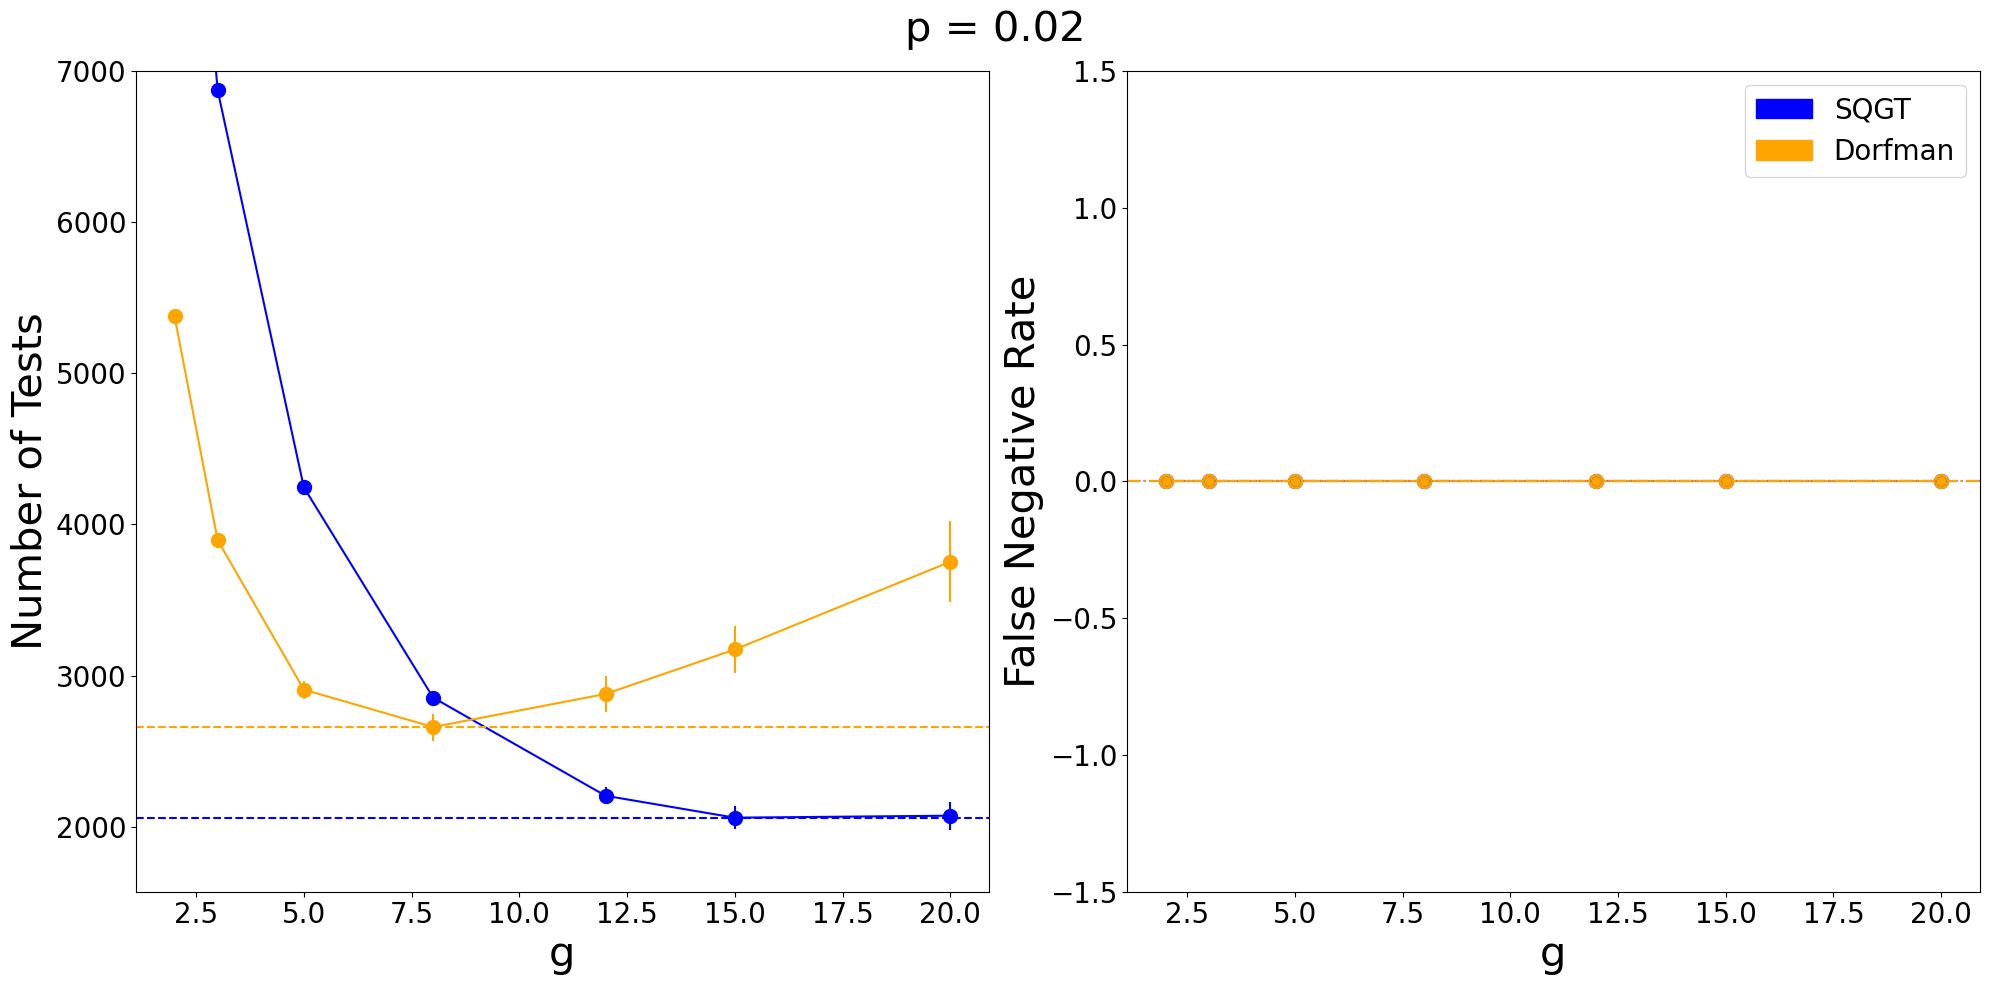

In [21]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
"""ax1.plot(ps,count_ls,marker='.',c='blue',markersize=20)
ax1.plot(ps,dorf_count_ls,marker='.',c='orange',markersize=20)
ax2.plot(ps,fnr_ls,marker='.',c='blue',markersize=20)
ax2.plot(ps,dorf_fnr_ls,marker='.',c='orange',markersize=20)
"""
ax1.plot(gs,count_lsg,marker='.',c='blue',markersize=20)
ax1.plot(gs,dorf_count_lsg,marker='.',c='orange',markersize=20)
ax1.errorbar(gs, count_lsg,
             yerr = np.array(count_sds),
             fmt ='o',c='blue')
ax1.errorbar(gs, dorf_count_lsg,
             yerr = np.array(dorf_count_sds),
             fmt ='o',c='orange')
ax2.plot(gs,fnr_lsg,marker='.',c='blue',markersize=20)
ax2.plot(gs,dorf_fnr_lsg,marker='.',c='orange',markersize=20)
ax2.errorbar(gs, fnr_lsg,
             yerr = np.array(fnr_sds),
             fmt ='o',c='blue')
ax2.errorbar(gs, dorf_fnr_lsg,
             yerr = np.array(dorf_fnr_sds),
             fmt ='o',c='orange')

legend_elements = [Patch(facecolor='blue', edgecolor='blue',
                         label='SQGT'),
                  Patch(facecolor='orange', edgecolor='orange',
                         label='Dorfman')]
ax2.legend(handles=legend_elements)
ax1.axhline(y=min(count_lsg),c='blue',linestyle='--')
ax1.axhline(y=min(dorf_count_lsg),c='orange',linestyle='--')
ax2.axhline(y=fnr_lsg[count_lsg.index(min(count_lsg))],c='blue',linestyle='dashdot')
ax2.axhline(y=dorf_fnr_lsg[dorf_count_lsg.index(min(dorf_count_lsg))],c='orange',linestyle='dashdot')
ax2.legend(handles=legend_elements, prop={'size': 20})
ax1.set_ylabel('Number of Tests',fontsize=30)
ax2.set_ylabel('False Negative Rate',fontsize=30)
ax1.set_xlabel('g',fontsize=30)
ax2.set_xlabel('g',fontsize=30)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
plt.suptitle("p = 0.02", fontsize=30)
ax2.set_ylim([-1.5, 1.5])
ax1.set_ylim(top=7000)
plt.tight_layout()
plt.savefig('02_no_err_sys_final.pdf', format="pdf")

In [22]:
p = 0.05
gs = [2,3,5,8,12,15,20]
count_lsg = []
fnr_lsg = []
fnr_sds = []
count_sds = []
for g in gs:
    count_r = []
    fnr_r =[]
    for r in range(30):
        loads = list(data_pos['log10Load']) + [0 for i in range(math.ceil(len(data_pos)/p) - len(data_pos))]
        data_table = pd.DataFrame(loads,columns=['log10Load'])
        data_table['IDs'] = [i for i in range(len(data_table))]
        data_table['toTest'] = [True for i in range(len(data_table))]
        data_table = data_table.sample(frac=1).reset_index(drop=True)
        data_table = data_table[:10000]
        data_table = run_baseline(data_table,36)
        th2 = 36+(np.log10(g)*np.abs(SLOPE))
        th1 = 21 +(np.log10(g)*np.abs(SLOPE))
        test1,count = two_step(data_table,g,th1,th2,36)
        cnf_matrix = confusion_matrix(test1['Truth'], test1['Final'])
        tn, fp, fn, tp = cnf_matrix.ravel()
        count_r.append(count)
        fnr_r.append(fn/(tp+fn))
    count_lsg.append(np.mean(count_r))
    fnr_lsg.append(np.mean(fnr_r))
    fnr_sds.append(np.std(fnr_r))
    count_sds.append(np.std(count_r))

In [23]:
p = 0.05
gs = [2,3,5,8,12,15,20]
dorf_count_lsg = []
dorf_fnr_lsg = []
dorf_fnr_sds = []
dorf_count_sds = []
for g in gs:
    count_r = []
    fnr_r =[]
    for r in range(30):
        loads = list(data_pos['log10Load']) + [0 for i in range(math.ceil(len(data_pos)/p) - len(data_pos))]
        data_table = pd.DataFrame(loads,columns=['log10Load'])
        data_table['IDs'] = [i for i in range(len(data_table))]
        data_table['toTest'] = [True for i in range(len(data_table))]
        data_table = data_table.sample(frac=1).reset_index(drop=True)
        data_table = data_table[:10000]
        data_table = run_baseline(data_table,36)
        th2 = 36+(np.log10(g)*np.abs(SLOPE))
        test1,count = dorfman(data_table,g,th2,36)
        cnf_matrix = confusion_matrix(test1['Truth'], test1['Final'])
        tn, fp, fn, tp = cnf_matrix.ravel()
        count_r.append(count)
        fnr_r.append(fn/(tp+fn))
    dorf_count_lsg.append(np.mean(count_r))
    dorf_fnr_lsg.append(np.mean(fnr_r))
    dorf_fnr_sds.append(np.std(fnr_r))
    dorf_count_sds.append(np.std(count_r))

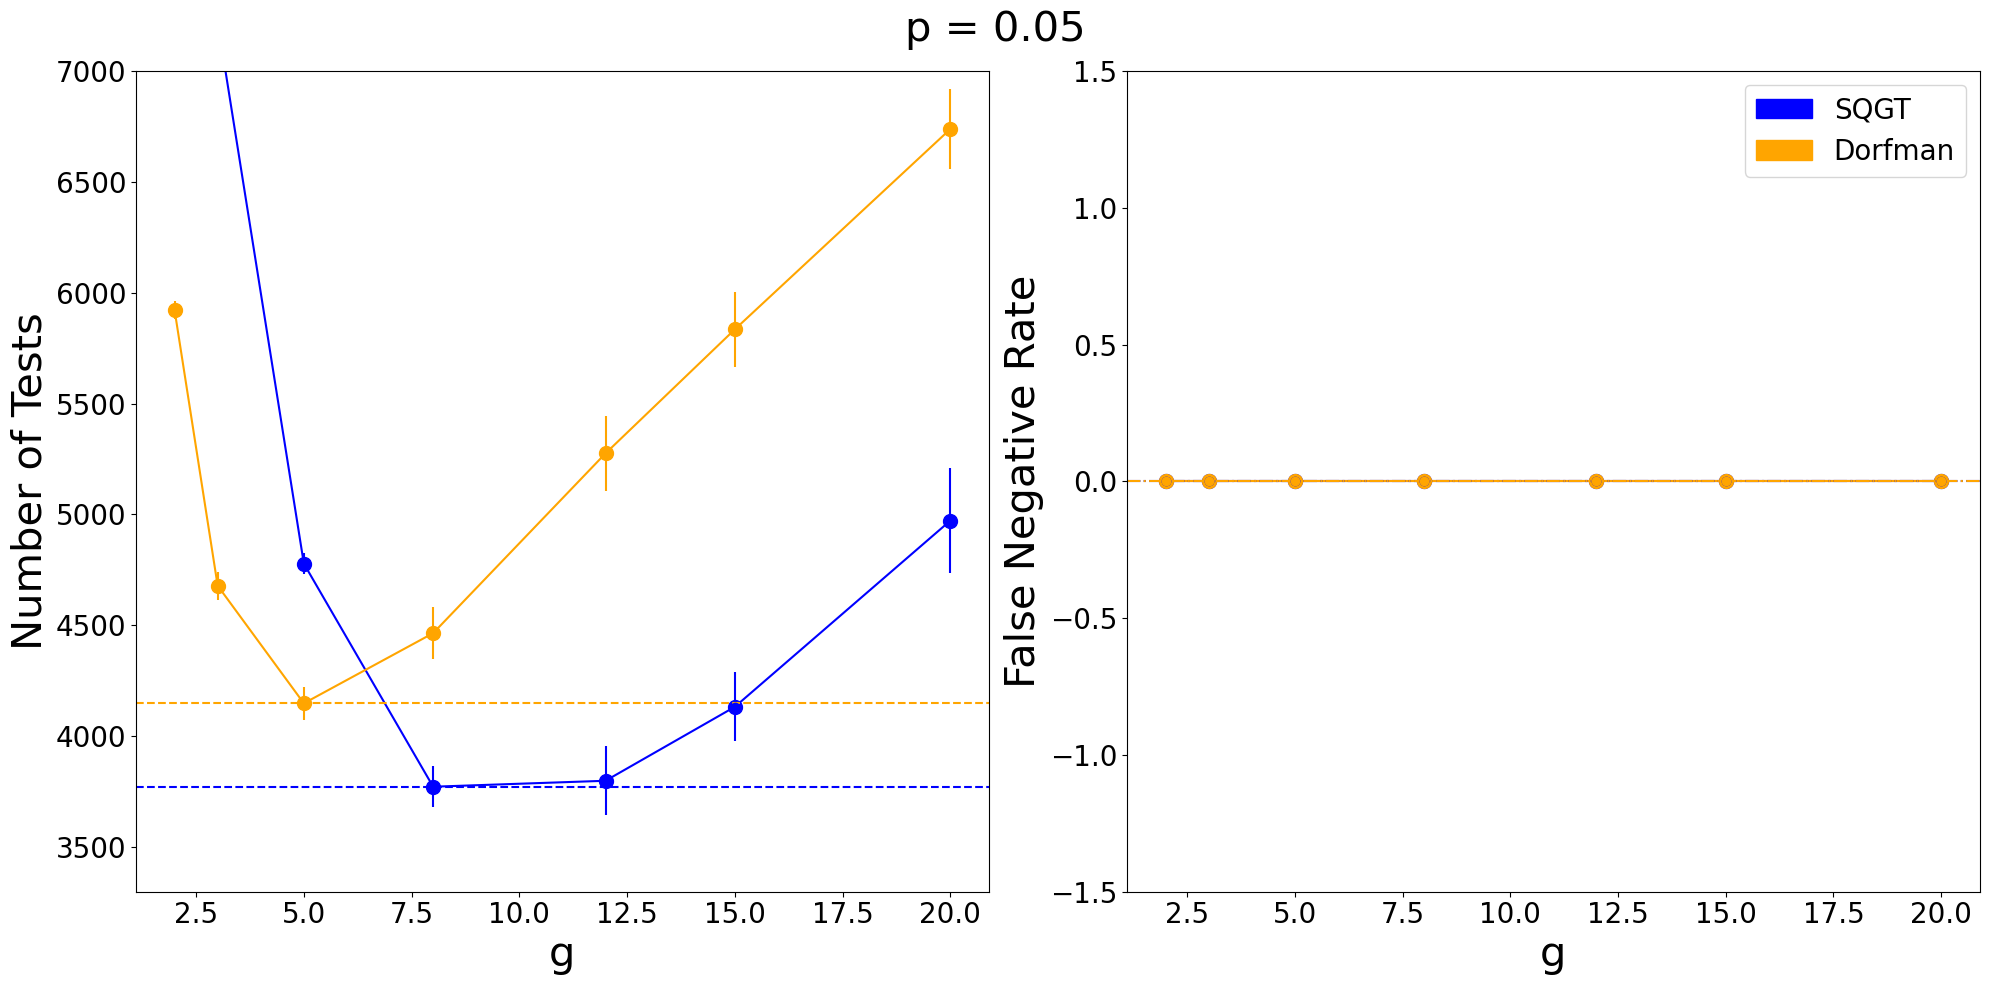

In [24]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
"""ax1.plot(ps,count_ls,marker='.',c='blue',markersize=20)
ax1.plot(ps,dorf_count_ls,marker='.',c='orange',markersize=20)
ax2.plot(ps,fnr_ls,marker='.',c='blue',markersize=20)
ax2.plot(ps,dorf_fnr_ls,marker='.',c='orange',markersize=20)
"""
ax1.plot(gs,count_lsg,marker='.',c='blue',markersize=20)
ax1.plot(gs,dorf_count_lsg,marker='.',c='orange',markersize=20)
ax1.errorbar(gs, count_lsg,
             yerr = np.array(count_sds),
             fmt ='o',c='blue')
ax1.errorbar(gs, dorf_count_lsg,
             yerr = np.array(dorf_count_sds),
             fmt ='o',c='orange')
ax2.plot(gs,fnr_lsg,marker='.',c='blue',markersize=20)
ax2.plot(gs,dorf_fnr_lsg,marker='.',c='orange',markersize=20)
ax2.errorbar(gs, fnr_lsg,
             yerr = np.array(fnr_sds),
             fmt ='o',c='blue')
ax2.errorbar(gs, dorf_fnr_lsg,
             yerr = np.array(dorf_fnr_sds),
             fmt ='o',c='orange')

legend_elements = [Patch(facecolor='blue', edgecolor='blue',
                         label='SQGT'),
                  Patch(facecolor='orange', edgecolor='orange',
                         label='Dorfman')]
ax2.legend(handles=legend_elements)
ax1.axhline(y=min(count_lsg),c='blue',linestyle='--')
ax1.axhline(y=min(dorf_count_lsg),c='orange',linestyle='--')
ax2.axhline(y=fnr_lsg[count_lsg.index(min(count_lsg))],c='blue',linestyle='dashdot')
ax2.axhline(y=dorf_fnr_lsg[dorf_count_lsg.index(min(dorf_count_lsg))],c='orange',linestyle='dashdot')
ax2.legend(handles=legend_elements, prop={'size': 20})
ax1.set_ylabel('Number of Tests',fontsize=30)
ax2.set_ylabel('False Negative Rate',fontsize=30)
ax1.set_xlabel('g',fontsize=30)
ax2.set_xlabel('g',fontsize=30)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
plt.suptitle("p = 0.05", fontsize=30)
ax2.set_ylim([-1.5, 1.5])
ax1.set_ylim(top=7000)
plt.tight_layout()
plt.savefig('05_no_err_sys_final.pdf', format="pdf")